## From BoW to Tf-Idf

In [58]:
import json
import pandas as pd
import sklearn.model_selection as modsel
from sklearn.feature_extraction import text
import sklearn.preprocessing as preproc
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Load Yelp business data

In [3]:
biz_f = open('/Users/eghazary/Downloads/yelp_academic_dataset_business.json')
biz_df = pd.DataFrame([json.loads(x) for x in biz_f.readlines()])
biz_f.close()

### Load Yelp review data

In [5]:
review_file = open('/Users/eghazary/Downloads/yelp_academic_dataset_review.json')
review_df = pd.DataFrame([json.loads(x) for x in review_file.readlines()])
review_file.close()

### Pull out only Nightlife and Restaurants businesses

In [7]:
two_biz = biz_df[biz_df.apply(lambda x: 'Nightlife' in x['categories'] or 'Restaurants' in x['categories'], axis=1)]

### Join with the reviews to get all reviews on the two types of business

In [8]:
twobiz_reviews = two_biz.merge(review_df, on='business_id', how='inner')

### Trim away the features we won't use

In [9]:
twobiz_reviews = twobiz_reviews[['business_id','name','stars_y','text','categories']]

### Create the target column--True for Nightlife businesses, and False otherwise

In [11]:
twobiz_reviews['target'] = twobiz_reviews.apply(lambda x: 'Nightlife' in x['categories'],axis=1)

### Create a class-balanced subsample to play with

In [27]:
nightlife = twobiz_reviews[twobiz_reviews.apply(lambda x:'Nightlife'in x['categories'], axis=1)]
restaurants = twobiz_reviews[twobiz_reviews.apply(lambda x:'Restaurants'in x['categories'], axis=1)]

nightlife_subset = nightlife.sample(frac=0.1, random_state=123)
restaurant_subset = restaurants.sample(frac=0.019, random_state=123)

combined = pd.concat([nightlife_subset, restaurant_subset])


In [28]:
print (len(nightlife_subset), len(restaurant_subset))

3014 3010


### Split into training and test datasets

In [32]:
training_data, test_data = modsel.train_test_split(combined, test_size=0.3, random_state=123)

In [33]:
training_data.shape

(4216, 6)

In [34]:
test_data.shape

(1808, 6)

### Represent the review text as a bag-of-words

In [38]:
bow_transform = text.CountVectorizer()
X_tr_bow = bow_transform.fit_transform(training_data['text'])
X_te_bow = bow_transform.transform(test_data['text'])
len(bow_transform.vocabulary_)

y_tr = training_data['target']
y_te = test_data['target']


### Create the tf-idf representation using the bag-of-words matrix

In [40]:
tfidf_trfm = text.TfidfTransformer(norm=None)
X_tr_tfidf = tfidf_trfm.fit_transform(X_tr_bow)
X_te_tfidf = tfidf_trfm.transform(X_te_bow)

### l2-normalize the bag-of-words representation

In [43]:
X_tr_l2 = preproc.normalize(X_tr_bow, axis=0)
X_te_l2 = preproc.normalize(X_te_bow, axis=0)

### Training logistic regression classifiers with default parameters

In [63]:
def simple_logistic_classify(X_tr, y_tr, X_test, y_test, description, _C=1.0):
    ### Helper function to train a logistic classifier and score on test data
    m = LogisticRegression(C=_C).fit(X_tr, y_tr)
    s = m.score(X_test, y_test)
    print ('Test score with', description, 'features:', s)
    return m

m1 = simple_logistic_classify(X_tr_bow, y_tr, X_te_bow, y_te, 'bow')
m2 = simple_logistic_classify(X_tr_l2, y_tr, X_te_l2, y_te, 'l2-normalized')
m3 = simple_logistic_classify(X_tr_tfidf, y_tr, X_te_tfidf, y_te, 'tf-idf')

Test score with bow features: 0.7527654867256637
Test score with l2-normalized features: 0.7599557522123894
Test score with tf-idf features: 0.75


### Tuning logistic regression hyperparameters with grid search

#### Specify a search grid, then do a 5-fold grid search for each of the feature sets

In [47]:
param_grid_ = {'C': [1e-5, 1e-3, 1e-1, 1e0, 1e1, 1e2]}

#### Tune classifier for bag-of-words representation

In [52]:
bow_search = modsel.GridSearchCV(LogisticRegression(), cv=5, param_grid=param_grid_)
bow_search.fit(X_tr_bow, y_tr)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1e-05, 0.001, 0.1, 1.0, 10.0, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

#### Tune classifier for L2-normalized word vector

In [53]:
l2_search = modsel.GridSearchCV(LogisticRegression(), cv=5, param_grid=param_grid_)
l2_search.fit(X_tr_l2, y_tr)


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1e-05, 0.001, 0.1, 1.0, 10.0, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

#### Tune classifier for tf-idf

In [54]:
tfidf_search = modsel.GridSearchCV(LogisticRegression(), cv=5, param_grid=param_grid_)
tfidf_search.fit(X_tr_tfidf, y_tr)


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1e-05, 0.001, 0.1, 1.0, 10.0, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

#### Plot the cross validation results in a box-and-whiskers plot to
#### visualize and compare classifier performance

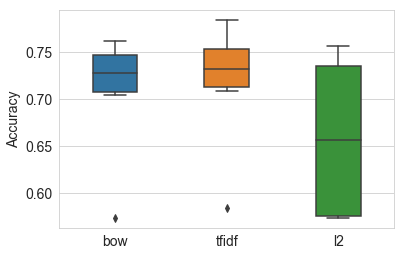

In [59]:
search_results = pd.DataFrame.from_dict({'bow': bow_search.cv_results_['mean_test_score'],'tfidf': tfidf_search.cv_results_['mean_test_score'],'l2': l2_search.cv_results_['mean_test_score']})
sns.set_style("whitegrid")
ax = sns.boxplot(data=search_results, width=0.4)
ax.set_ylabel('Accuracy', size=14)
ax.tick_params(labelsize=14)

#### Train a final model on the entire training set, using the best hyperparameter settings found previously. Measure accuracy on the test set.

In [64]:
m1 = simple_logistic_classify(X_tr_bow, y_tr, X_te_bow, y_te, 'bow', _C=bow_search.best_params_['C'])
m2 = simple_logistic_classify(X_tr_l2, y_tr, X_te_l2, y_te, 'l2-normalized', _C=l2_search.best_params_['C'])
m3 = simple_logistic_classify(X_tr_tfidf, y_tr, X_te_tfidf, y_te, 'tf-idf', _C=tfidf_search.best_params_['C'])

Test score with bow features: 0.7627212389380531
Test score with l2-normalized features: 0.7605088495575221
Test score with tf-idf features: 0.7936946902654868
